In [121]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from typing import Union

## Question 1

In [193]:
def run_LIF_with_conditioning(
        conditioned_stimulus_times,
        unconditioned_stimulus_times,
        delta_g_CS, 
        total_time = 1000,  # ms
        c_m = 10,  # nF/mm^2
        g_L = 1.0,  # microS/mm^2
        E_L = -70,  # mV
        E_ex = 0,
        V_th = -54,  # mV
        V_reset = -80,  # mV
        tau_ex = 5,  # ms
        
        delta_g_US = 1.2,  # microS / mm^2; unconditional stimulus
        dt = 0.01,  # ms
        
        A_LTP = 0.35, # microS / mm^2
        A_LTD = 0.4, # microS / mm^2
        tau_LTP = 25, # ms
        tau_LTD = 35, # ms
        
        min_delta_g_CS = 0, # microS / mm^2
        max_delta_g_CS = 1.2 # microS / mm^2
):
    
    time_steps = np.linspace(0, total_time, int(total_time / dt + 1))  # creating timespace with dt=0.01 ms
    voltages = np.zeros_like(time_steps)
    synaptic_conductance = np.zeros_like(time_steps) # g_ex
    delta_g_CS_vals = np.zeros_like(time_steps) # to store the time dynamics of delta_g_CS
    delta_g_CS_vals[0] = delta_g_CS
    
    spike_times = np.zeros_like(time_steps)
    voltages[0] = E_L
    
    delta_t_LTP = np.inf # ms; time since the last presynaptic spike activated by conditioned stimulus
    timestep_of_last_conditioned_presynaptic_spike = None
    
    delta_t_LTD = np.inf # ms; time since most recent postsynaptic spike
    timestep_of_last_postsynaptic_spike = None
    
    unconditioned_stimulus_times_timesteps = [int(time / dt) for time in unconditioned_stimulus_times]
    conditioned_stimulus_times_timesteps = [int(time / dt) for time in conditioned_stimulus_times]
    
    for idx in tqdm(range(len(time_steps))):
    
        if idx in unconditioned_stimulus_times_timesteps:
            synaptic_conductance[idx] += delta_g_US
            
        if idx in conditioned_stimulus_times_timesteps:
            synaptic_conductance[idx] += delta_g_CS
            timestep_of_last_conditioned_presynaptic_spike = idx
            
            # spike-timing dependent plasticity - LTD
            if timestep_of_last_postsynaptic_spike is not None:
                # if postsynaptic spike occured - recompute delta_t_LTD
                delta_t_LTD = (idx - timestep_of_last_postsynaptic_spike) * dt
            
            delta_g_CS -= A_LTD * np.exp(- delta_t_LTD / tau_LTD)
            if delta_g_CS < min_delta_g_CS:
                delta_g_CS = min_delta_g_CS
            
    
        if voltages[idx] >= V_th:
            voltages[idx] = V_reset
            spike_times[idx] = 1
            
            # spike-timing dependent plasticity - LTP
            if timestep_of_last_conditioned_presynaptic_spike is not None:
                # if presynaptic spike occured - recompute delta_t_LTP
                delta_t_LTP = (idx - timestep_of_last_conditioned_presynaptic_spike) * dt
                
            delta_g_CS += A_LTP * np.exp(- delta_t_LTP / tau_LTP)
            if delta_g_CS > max_delta_g_CS:
                delta_g_CS = max_delta_g_CS
            
            timestep_of_last_postsynaptic_spike = idx
            
    
        dg_ex = -synaptic_conductance[idx] * (dt / tau_ex)
        dV = (-g_L * (voltages[idx] - E_L) - synaptic_conductance[idx] * (voltages[idx] - E_ex)) * (dt / c_m)
        
        if idx < len(time_steps) - 1:
            voltages[idx + 1] = voltages[idx] + dV
            synaptic_conductance[idx + 1] = synaptic_conductance[idx] + dg_ex
        
        delta_g_CS_vals[idx] = delta_g_CS
        
    voltages[spike_times == 1] = 40  # for spike visualization
    synaptic_current = synaptic_conductance * (voltages - E_ex)  # nA / mm^2
    return time_steps, voltages, synaptic_current, delta_g_CS_vals

  0%|          | 0/100001 [00:00<?, ?it/s]

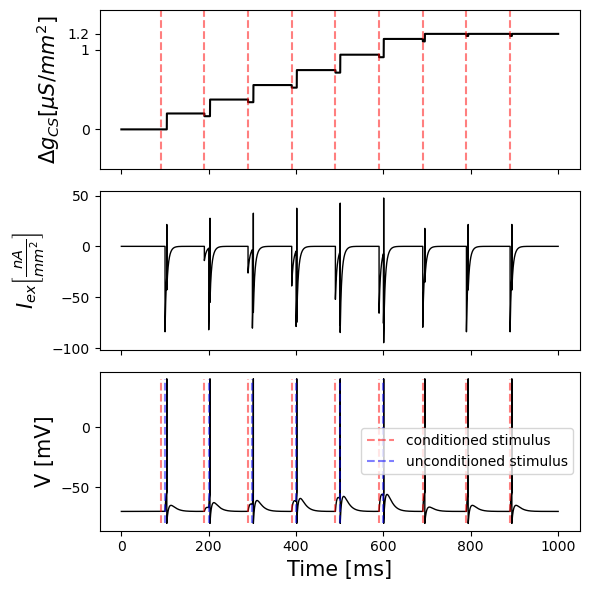

In [194]:
delta_g_CS = 0 # microS / mm^2; conditional stimulus; initial value
unconditioned_stimulus_times = [100, 200, 300, 400, 500, 600]  # ms
conditioned_stimulus_times = [90, 190, 290, 390, 490, 590, 690, 790, 890]  # ms

time_steps, voltages, synaptic_current, delta_g_CS_vals = run_LIF_with_conditioning(
    conditioned_stimulus_times,
    unconditioned_stimulus_times,
    delta_g_CS,
    total_time=1000 # ms
)

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, tight_layout=True)
axs[0].plot(time_steps, delta_g_CS_vals, color='black')
axs[0].set_yticks([0, 1, 1.2], [0, 1, 1.2])
axs[0].set_ylim([-0.5, 1.5])
axs[0].vlines(conditioned_stimulus_times, -80, 40, linestyles='--', alpha=0.5, color='red',
              label='conditioned stimulus')
axs[0].set_ylabel(r'$\Delta g_{CS} [\mu S / mm^2]$', fontsize=15)
axs[1].plot(time_steps, synaptic_current, color='black', linewidth=1)
axs[1].set_ylabel(r'$I_{ex}  \left[\frac{ nA}{mm^2}\right]$', fontsize=15)
axs[2].plot(time_steps, voltages, color='black', linewidth=1)
axs[2].vlines(conditioned_stimulus_times, -80, 40, linestyles='--', alpha=0.5, color='red',
              label='conditioned stimulus')
axs[2].vlines(unconditioned_stimulus_times, -80, 40, linestyles='--', alpha=0.5, color='blue',
              label='unconditioned stimulus')
axs[2].set_ylabel(r'V [mV]', fontsize=15)
axs[2].set_xlabel('Time [ms]', fontsize=15)
axs[2].legend()


output_dir = './plots/'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'q1_run_1.png'))
plt.show()

  0%|          | 0/100001 [00:00<?, ?it/s]

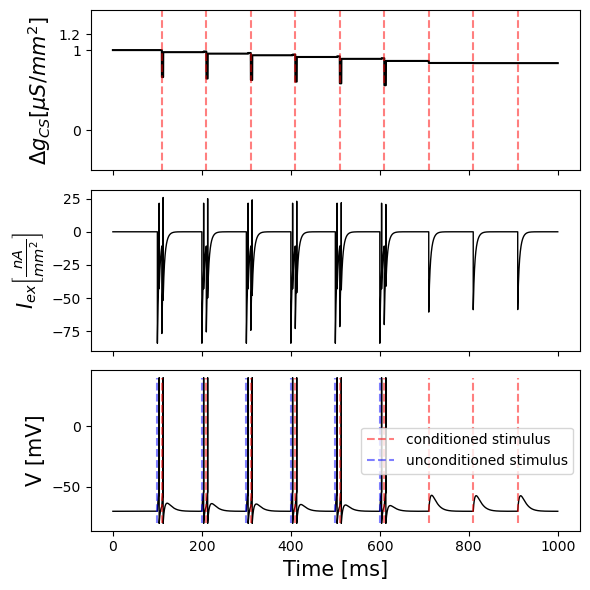

In [195]:
delta_g_CS = 1 # microS / mm^2; conditional stimulus; initial value
unconditioned_stimulus_times = [100, 200, 300, 400, 500, 600]  # ms
conditioned_stimulus_times = [110, 210, 310, 410, 510, 610, 710, 810, 910]  # ms

time_steps, voltages, synaptic_current, delta_g_CS_vals = run_LIF_with_conditioning(
    conditioned_stimulus_times,
    unconditioned_stimulus_times,
    delta_g_CS,
    total_time=1000 # ms
)

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True, tight_layout=True)
axs[0].plot(time_steps, delta_g_CS_vals, color='black')
axs[0].set_yticks([0, 1, 1.2], [0, 1, 1.2])
axs[0].set_ylim([-0.5, 1.5])
axs[0].vlines(conditioned_stimulus_times, -80, 40, linestyles='--', alpha=0.5, color='red',
              label='conditioned stimulus')
axs[0].set_ylabel(r'$\Delta g_{CS} [\mu S / mm^2]$', fontsize=15)
axs[1].plot(time_steps, synaptic_current, color='black', linewidth=1)
axs[1].set_ylabel(r'$I_{ex}  \left[\frac{ nA}{mm^2}\right]$', fontsize=15)
axs[2].plot(time_steps, voltages, color='black', linewidth=1)
axs[2].vlines(conditioned_stimulus_times, -80, 40, linestyles='--', alpha=0.5, color='red',
              label='conditioned stimulus')
axs[2].vlines(unconditioned_stimulus_times, -80, 40, linestyles='--', alpha=0.5, color='blue',
              label='unconditioned stimulus')
axs[2].set_ylabel(r'V [mV]', fontsize=15)
axs[2].set_xlabel('Time [ms]', fontsize=15)
axs[2].legend()


output_dir = './plots/'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'q1_run_2.png'))
plt.show()

## Question 2

In [177]:
def simulate_and_plot_constant_firing_rate(
        r: Union[int, np.ndarray], # firing rate in Hz, either int when constant, or values per each timestep (array of size int(total_time / dt + 1))
        dt: float = 0.01, # ms
        total_time = 1000, # ms 
        plot=True,
        filename ='q2.png' # for saving the plot
        ):
    time_steps = np.linspace(0, total_time, int(total_time / dt + 1))  # creating time space with dt=0.01 ms
    
    if isinstance(r, int):
        # to keep units consistent we convert firing rates from Hz to spikes per ms
        r_ms = r / 1000 # firing rate per ms
        r_ms_arr = np.ones_like(time_steps) * r_ms
        spike_probs = r_ms_arr * dt # porbability of presynaptic spike at each time step
    else:
        spike_probs = r / 1000 * dt
    
    transmitter_release_prob = {'depressing_synapse': np.zeros_like(time_steps),
                                'facilitating_synapse': np.zeros_like(time_steps)}
    
    release_prob_time_constant = {'depressing_synapse': 300, # ms
                             'facilitating_synapse': 100 # ms                  
                             }
    
    release_prob_resting_value = {'depressing_synapse': 1, 
                             'facilitating_synapse': 0               
                             }
    
    spike_times = np.zeros_like(time_steps) # spike times of presynaptic neuron
    
    transmission_times = {'depressing_synapse': np.zeros_like(time_steps),
                          'facilitating_synapse': np.zeros_like(time_steps)}
    
    # initial values:
    transmitter_release_prob['depressing_synapse'][0] = 1
    transmitter_release_prob['facilitating_synapse'][0] = 0
    
    
    for idx in range(len(time_steps) - 1):
        spike_times[idx] = np.random.binomial(n=1, p=spike_probs[idx] , size=1)
        
        if spike_times[idx] == 1:
            # every time there is a presynaptic spike, synapses may release neurotranmitters with respective probabilities
            
            # recording transmission from both synapses
            transmission_times['depressing_synapse'][idx] = np.random.binomial(
                n=1, p=transmitter_release_prob['depressing_synapse'][idx], size=1)
            if transmission_times['depressing_synapse'][idx] == 1:
                transmitter_release_prob['depressing_synapse'][idx] = 0
            
            transmission_times['facilitating_synapse'][idx] = np.random.binomial(n=1, p=transmitter_release_prob['facilitating_synapse'][idx], size=1)
            
            transmitter_release_prob['facilitating_synapse'][idx] += 0.1 * (1 - transmitter_release_prob['facilitating_synapse'][idx])
        
        
        dP_facilitating = (release_prob_resting_value['facilitating_synapse'] - transmitter_release_prob['facilitating_synapse'][idx]) * (dt / release_prob_time_constant['facilitating_synapse'])
        dP_depressing = (release_prob_resting_value['depressing_synapse'] - transmitter_release_prob['depressing_synapse'][idx]) * (dt / release_prob_time_constant['depressing_synapse'])
        
        transmitter_release_prob['facilitating_synapse'][idx + 1] = transmitter_release_prob['facilitating_synapse'][idx] + dP_facilitating
        transmitter_release_prob['depressing_synapse'][idx + 1] = transmitter_release_prob['depressing_synapse'][idx] + dP_depressing
    
    if plot:
        fig, axs = plt.subplots(5, 1, figsize=(15, 6), sharex=True, tight_layout=True)
    
        axs[0].vlines(time_steps[spike_times == 1], -0, 40, linestyles='solid', alpha=0.5, color='black')
        axs[0].set_yticks([], [])
        if isinstance(r, int):
            axs[0].set_title(f'Presynaptic spikes (firing rate r={r} Hz')
        else:
            axs[0].set_title(f'Presynaptic spikes')

        
        axs[1].plot(time_steps, transmitter_release_prob['depressing_synapse'], linestyle='solid', alpha=1, color='blue')
        axs[1].set_yticks([0, 0.5, 1], [0, 0.5, 1])
        axs[1].set_title(f'Probability of transmission from depressing synapse')
        
        axs[2].vlines(time_steps[transmission_times['depressing_synapse'] == 1], -0, 40, linestyles='solid', alpha=1, color='blue')
        axs[2].set_yticks([], [])
        axs[2].set_title(f'Transmission from depressing synapse')
        
        
        axs[3].plot(time_steps, transmitter_release_prob['facilitating_synapse'], linestyle='solid', alpha=1, color='red')
        axs[3].set_yticks([0, 0.5, 1], [0, 0.5, 1])
        axs[3].set_title(f'Probability of transmission from facilitating synapse')
        
        axs[4].vlines(time_steps[transmission_times['facilitating_synapse'] == 1], -0, 40, linestyles='solid', alpha=1, color='red')
        axs[4].set_yticks([], [])
        axs[4].set_title(f'Transmission from facilitating synapse')
        axs[4].set_xlabel('Time [ms]', fontsize=15)
        # axs[2].legend()
        
        
        output_dir = './plots/'
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, filename), dpi=300)
        plt.show()
    return transmitter_release_prob, transmission_times

  0%|          | 0/100000 [00:00<?, ?it/s]

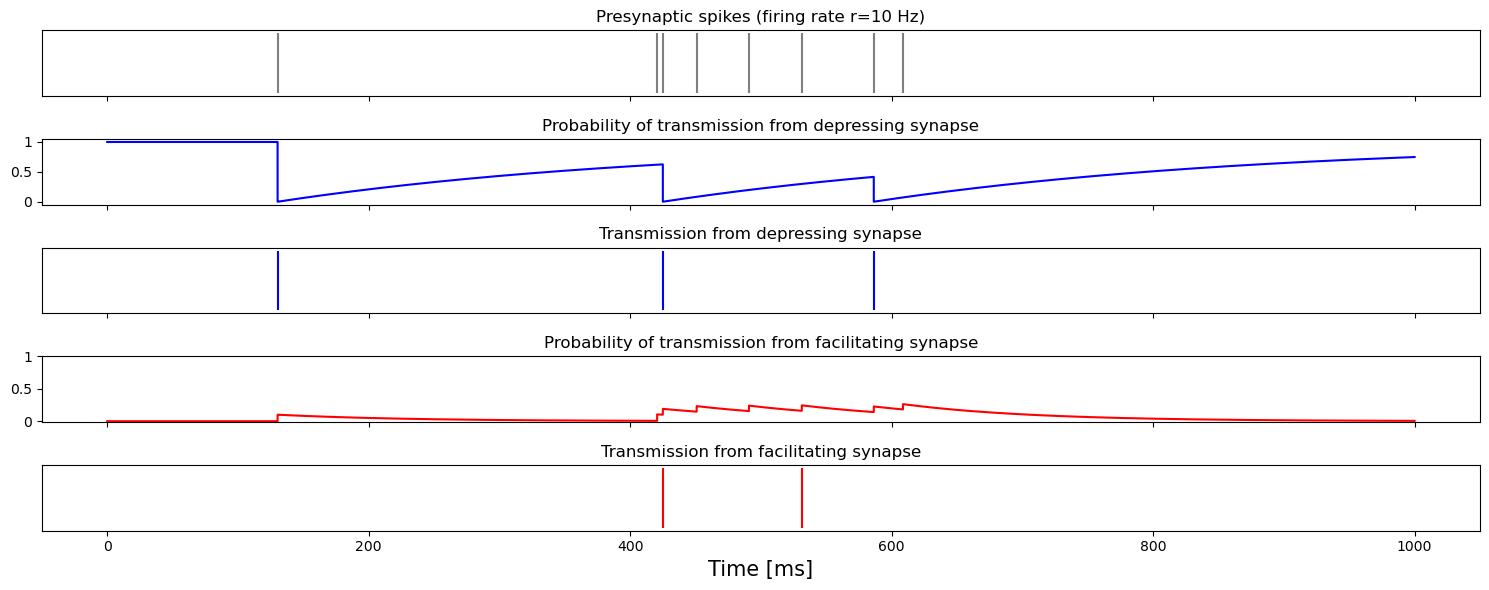

  0%|          | 0/100000 [00:00<?, ?it/s]

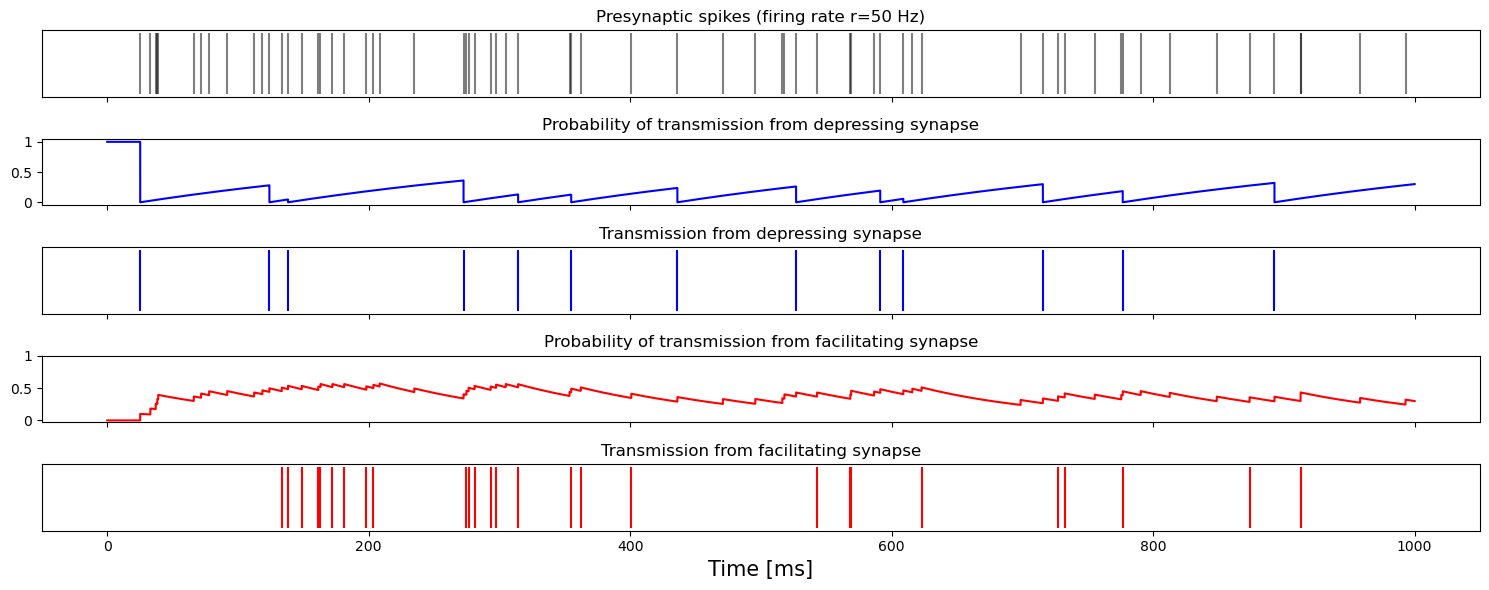

  0%|          | 0/100000 [00:00<?, ?it/s]

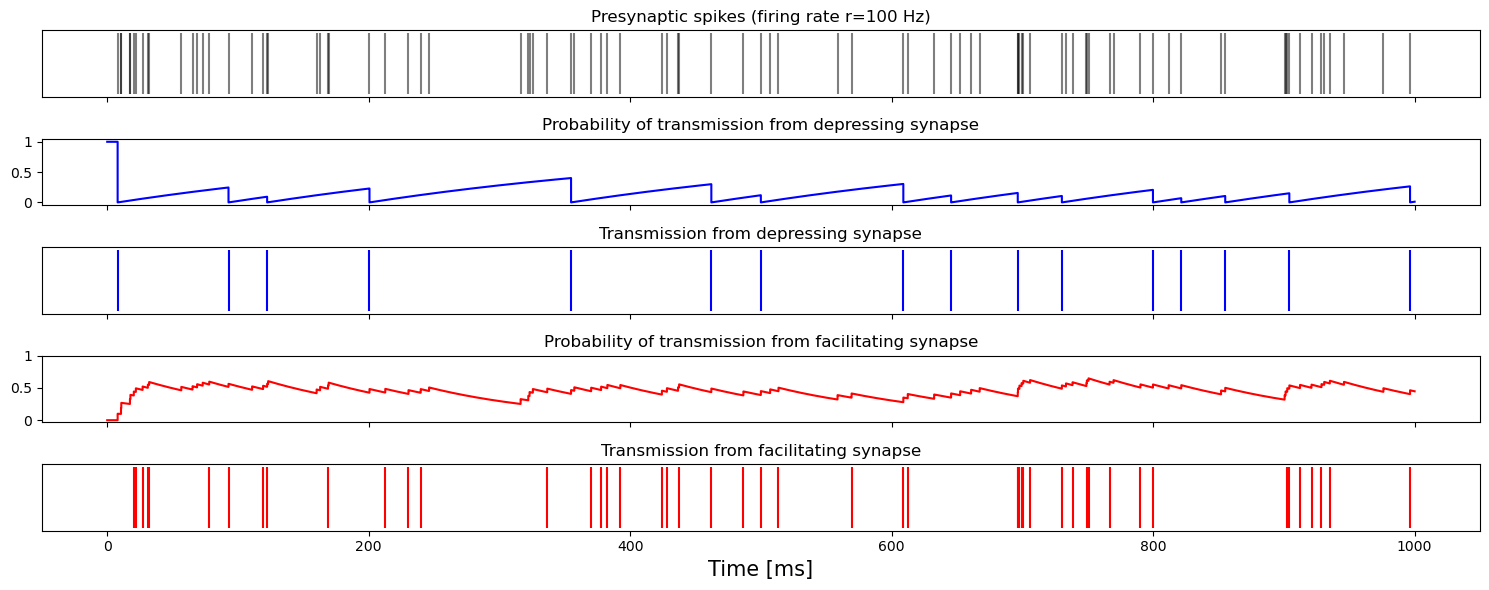

In [144]:
for r in [10, 50, 100]:
    _, _ = simulate_and_plot_constant_firing_rate(r=r, filename=f'q2_firing_rate_{r}_Hz.png')

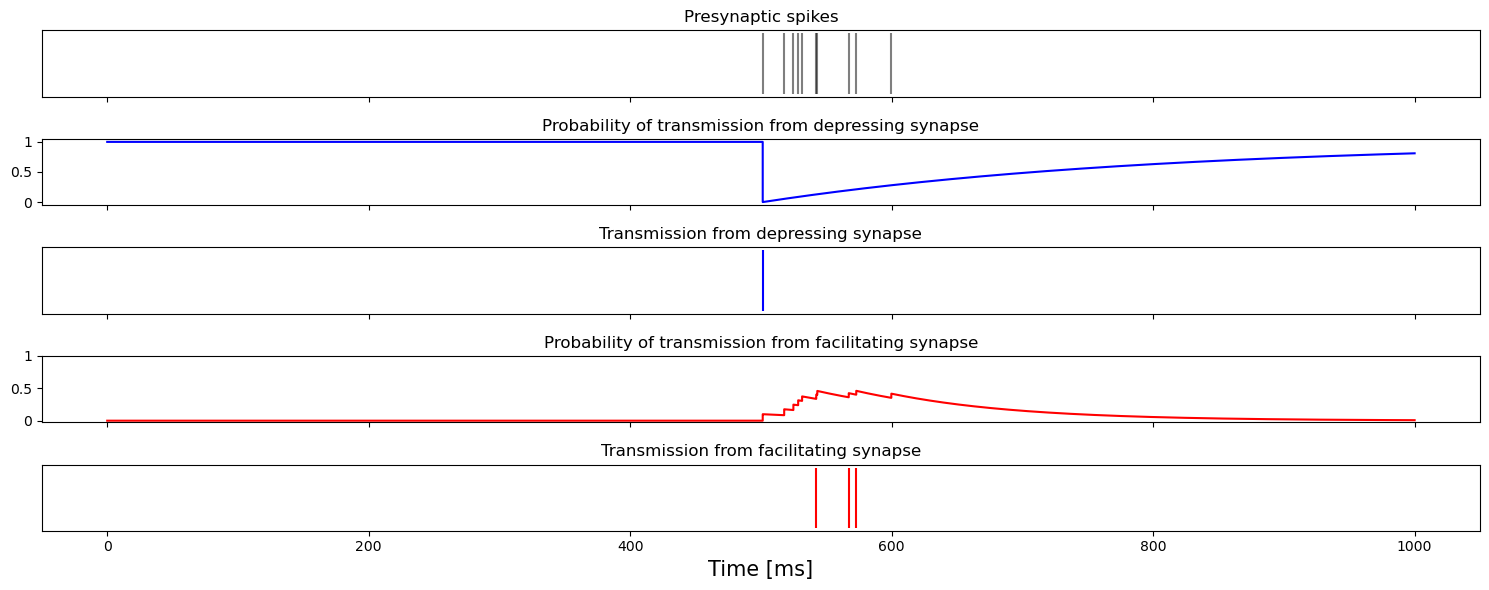

In [178]:
total_time = 1000
dt = 0.01
time_steps = np.linspace(0, total_time, int(total_time / dt + 1)) 
r = np.zeros_like(time_steps)
r[np.logical_and(time_steps >= 500, time_steps <= 600)] = 100
_, _ = simulate_and_plot_constant_firing_rate(r, filename='q2_100_Hz_btw_500_and_600_ms.png')

In [171]:
transmission_rates = {'depressing_synapse': np.zeros(101),
                      'facilitating_synapse': np.zeros(101)}
rates = range(101)
total_time = 10000 # ms
for idx, r in tqdm(enumerate(rates)):
    _, transmission_times = simulate_and_plot_constant_firing_rate(r=r, plot=False, total_time=total_time)
    for key in transmission_times.keys():
        transmission_rates[key][idx] = transmission_times[key].sum()  / (total_time * 0.001) # rate per second

0it [00:00, ?it/s]

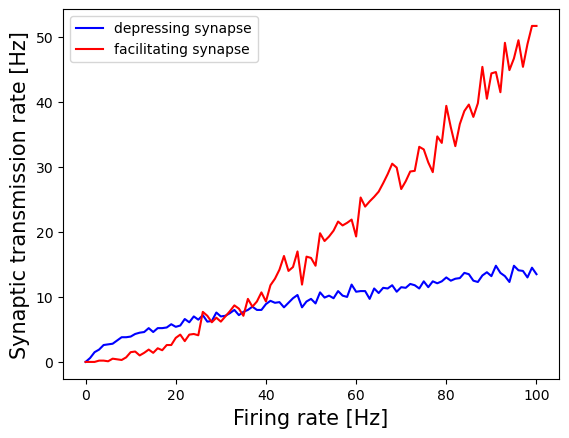

In [176]:
fig, axs = plt.subplots()
axs.plot(rates, transmission_rates['depressing_synapse'], color='blue', label='depressing synapse')
axs.plot(rates, transmission_rates['facilitating_synapse'], color='red', label='facilitating synapse')
axs.set_xlabel('Firing rate [Hz]', fontsize=15)
axs.set_ylabel('Synaptic transmission rate [Hz]', fontsize=15)
axs.legend()
plt.savefig(os.path.join(output_dir, 'transmission_rates.png'), dpi=300)
plt.show()